## Carbon-I Testbed Prototype

A prototype instrument has already been developed at JPL to demonstrate the Carbon-I measurement concept. This **testbed** incorporates a Dyson block, grating, and focal-plane array (FPA) matching Carbon-I’s anticipated optical design and performance specifications. Through laboratory measurements, the testbed can validate key elements such as **spectral resolution**, **imaging fidelity**, **throughput**, and **straylight** characteristics. These  demonstrations can confirm that Carbon-I’s architecture is both **technically feasible** and **robust**, ensuring confidence as we proceed toward a flight-ready instrument. 

In its current setup, the **testbed spectra** are measured under a **warm environment**, so the system is not fully aligned at flight operating temperatures. Consequently, the **spectral response function (SRF)** in these early demonstrations will appear more **fuzzy** than what we expect under cold, flight-like alignment conditions—a refinement that will be investigated in subsequent testbed campaigns.

---

Below, we walk through the **testbed-spectra fitting** procedure using measurements from a **light source** paired with a **CH<sub>4</sub> gas cell**. All examples here leverage the **Julia** programming language, chosen for its **high-level syntax** and **near-C speed**, making it ideally suited for the **Carbon-I** data processing pipeline. 

> First, we need to import some packages in Julia

In [14]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM
# Using standard Julia packages for Linear albegra, Differentiation, etc.
using SpecialPolynomials, FiniteDiff, LinearAlgebra
using DelimitedFiles, ImageFiltering, ForwardDiff, DiffResults
# Using the Makie package for plotting
using CairoMakie

  Activating project at `~/code/gitHub/CarbonI`


> Reading in the testbed spectra, stored as simple CSV file:

In [15]:
testbed_ch4 = readdlm("../../data/20250131 CITB CH4.csv",',');

> Loading Methane Spectroscopy from a pre-computed cross section table (tools included in vSmartMOM) and then computing the cross section of CH<sub>4</sub>  at the temperature and pressure in the laboratory (WAGs)

In [16]:
# Load Cross section database
ch4 = vSmartMOM.load_interpolation_model(CarbonI.xs_folder*"/ch4_model.jld2")
# Generate cross section at TestBed condition
p = 940.0 # Pressure in hPa
T = 290.0 # Temperature in K
Δwl = 0.01 # Resolution in nm
# Define high resolution wavelength grid (needs to be larger than the Carbon-I wavelength range to account for the SRF impact at the edges)
wl_grid_hr = 2030:Δwl:2398
xs_ch4  = reverse(vSmartMOM.absorption_cross_section(ch4, wl_grid_hr, p, T; wavelength_flag=true)); # Has to be reversed to match the order of the data (as table is in wavenumber)


> Define an Instrument function (using tools developed in Carbon-I), modeling the Spectral Response Function as a mix of two boxcar functions (for slit and detector pixel) as well as a Gaussian (for optical effects)

In [17]:
# Define an instrument (Convolution of 2 Box kernels with a Gaussian):
FWHM  = 2.5  # Full Width at Half Maximum in nm 
SSI  = 0.7   # Spectral Sampling Interval in nm
# Define the kernels:
# Spectral response function of the slit (2*SSI)
kern1 = CarbonI.box_kernel(2*SSI, Δwl)
# Spectral response function of the optics (Gaussian)
kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
# Spectral response function of the pixel (1*SSI)
kern3 = CarbonI.box_kernel(SSI, Δwl)
# Combine the kernels:
kernf = imfilter(imfilter(kern1, kern2), kern3)
# Generate the instrument (stores convolution kernel and wavelength grid):
CarbonI_SRF = CarbonI.KernelInstrument(kernf, collect(2036.7:SSI:2394.4));

> Model Transmission with a first guess of the vertical column density in the cell (8e19molec/cm2 here, which is roughly a double-pass through the atmosphere).

In [18]:
vcd = 0.8e20 # molec/cm²
# Transmission of entire cell:
T_CH4 = exp.(-xs_ch4*vcd)
# Transmission of instrument:
T_CH4_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T_CH4);

> Plot the **unfitted** modeled and measured spectra as well as the high resolution transmission computed before convolution to the Carbon-I grid

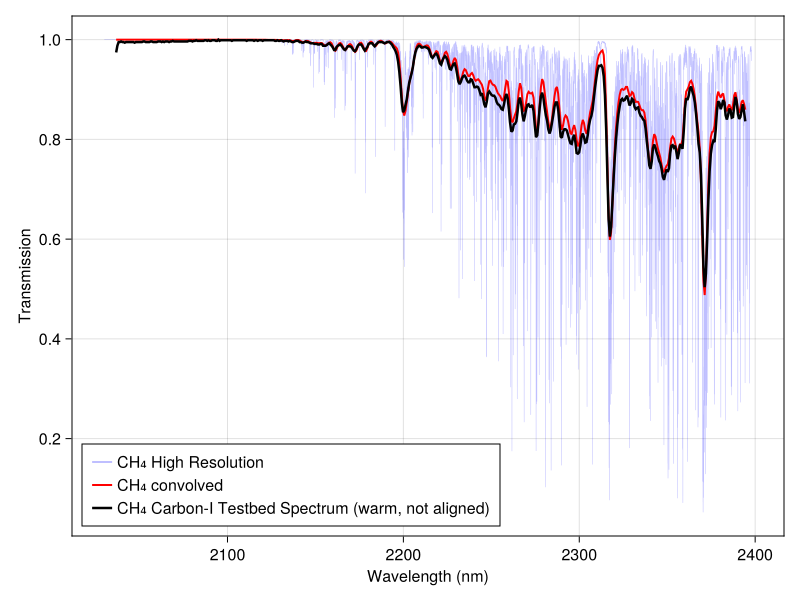

In [19]:
f = Figure(resolution = (800, 600))
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
lines!(ax, wl_grid_hr, T_CH4, color = :blue, linewidth = 0.5, alpha=0.25, label = "CH₄ High Resolution")
lines!(ax, CarbonI_SRF.ν_out, T_CH4_conv, color = :red, linewidth = 2.0, label = "CH₄ convolved")
lines!(ax, testbed_ch4[:,1], testbed_ch4[:,2]./maximum(testbed_ch4[:,2]), color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(position = :lb)
f

### Setting up a spectral fit

---

Now comes one of the most important parts of our fitting routine: **establishing a simple forward model** for the testbed spectra. Below is an example function in **Julia** that takes in a state vector containing parameters like wavelength offset, vertical column density, and instrument SRF specifications, and returns the modeled transmission curve. This function references **CH₄ cross sections**, applies **kernels** to simulate Carbon-I’s instrument resolution, and multiplies the resulting convolved spectrum by a **baseline polynomial** term to account for broad-band absorption structures that might come from the gas cell windows (similar to how surface albedo variationscan vary the broad-band variations in observed spectra when measured from space).

---

First, we define a simple forward model F(x) that maps our state vector x to modeled measurements.  x includes spectral calibration, vertical column density of the target gas, FWHM of the SRF, polynomial for broad band features.

In [37]:
# Set up a simple forward model to fit the data
function forward_model_testbed(x::AbstractArray{FT} ;xs_ch4 = xs_ch4, wl_grid_hr = wl_grid_hr, Δwl=Δwl, ind=ind) where {FT}
    ############# Extract the parameters of the state vector: ################  
    # Start Wavelength
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    # Fixed grid subset for now:
    # ind = 50:500
    # Compute Carbon-I grid as 2nd order polynomial of the index
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    # Vertical Column density (in molec/cm2):
    vcd = x[4]
    # FWHM (Full Width at Half Maximum)
    FWHM = x[5]
    # Poynomial terms
    poly = Legendre(x[6:end])

    ############# Start of the forward model ################################  
    # Compute total optical thickness (cross section * vertical column density)
    τ = xs_ch4 * vcd
    # Compute Transmission
    T = exp.(-τ)
    #@show T
    # Define the instrument SRF:
    #SSI  = 0.7
    # Kernel 1 simulates slit width as boxcar:
    kern1 = CarbonI.box_kernel(2SSI, Δwl)
    # Gaussian kernel simulates the resolution of the instrument:
    kern2 = CarbonI.gaussian_kernel(FWHM, Δwl)
    # Kernel 3 reresents the pixel itself (1*SSI boxcar)
    kern3 = CarbonI.box_kernel(SSI, Δwl)
    # Combine the kernels, basically a multiplication of their Fourier Transforms:
    kernf = imfilter(imfilter(kern1, kern2), kern3)
    # Generate the Carbon-I SRF kernel (which includes resampling to the final grid)
    CarbonI_SRF = CarbonI.KernelInstrument(kernf, carbonI_wlGrid);
    
    # Convolve with instrument function
    T_conv = CarbonI.conv_spectra(CarbonI_SRF, wl_grid_hr, T)
    x_poly = CarbonI.rescale_x(CarbonI_SRF.ν_out)
    # Multiply Convolved transmission with the baseline polynomial
    return T_conv .* poly.(x_poly)
end

# Just a simple function to compute the grid from the state vector outside of the forward model (lazy)
function getGrid(x; ind=ind)
    wl_start = x[1]
    # SSI
    SSI = x[2]
    # SSI change in square
    SSI_square  = x[3]
    
    carbonI_wlGrid = wl_start .+ ind * SSI .+  ind.^2 * SSI_square
    return carbonI_wlGrid
end

getGrid (generic function with 1 method)

> Now we can define a **prior** state vector and run the forward model. Note that this is **not optimized** but just evaluation the forward model at our first guess

In [21]:
x = [2036.7, 0.7, 0, 0.8e20, 2.5,  1.0, 0.0e-10, 0.0e-10, 0.0e-10, 0.0e-10,0.0e-10, 0.0e-10, 0.0e-10,0.0e-10,0.0e-10, 0.0e-10,0.0e-10];
ind = 1:510
yy = forward_model_testbed(x);
wl_grid = getGrid(x);

> Now we just plot it overlay the measured spectrum. It looks pretty good but is of course not yet **optimized**, i.e. we aim to minimize the squared residuals of (y-F(x))

In [33]:

function plotFit()
    f = Figure(resolution = (800, 600))
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    lines!(ax, wl_grid, yy, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
    lines!(ax, testbed_ch4[:,1], testbed_ch4[:,2]./maximum(testbed_ch4[:,2]), color = :gray, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    axislegend(position = :lb)
    f
end

plotFit (generic function with 1 method)

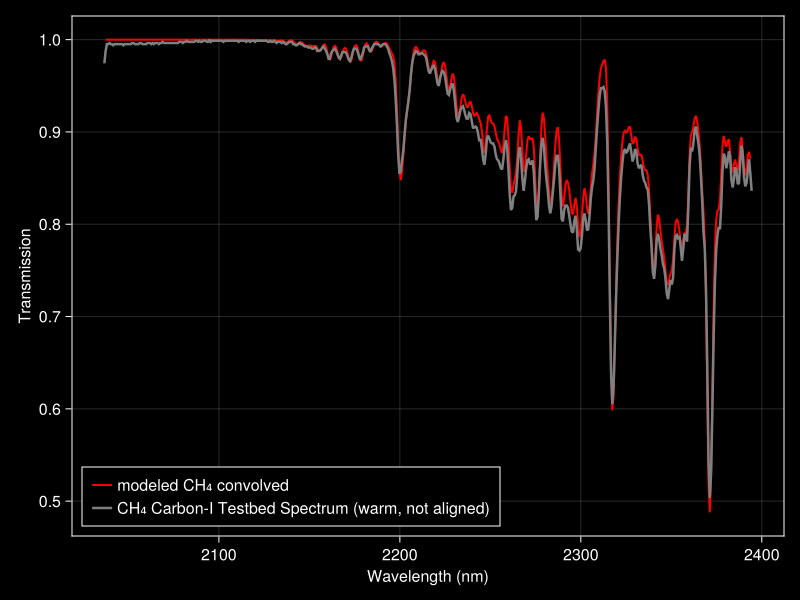

In [34]:
with_theme(plotFit, theme_black())

> Now we can set up an actual first defining the prior and error covariance matrices (a bit overkill for this application but is provides flexibility)

In [39]:
# Define the detector indices to include in the fit:
ind = 50:500

# Number of iterations:
n_iter = 5
# Initiate 2D array to store the state vector at each iteration
x_all = zeros(length(x),n_iter+1);
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y = testbed_ch4[:,2]./maximum(testbed_ch4[:,2]);
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y = y[ind.+1];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y)
# Set first guess as the first column of the state vector array
x_all[:,1] .= x;
# Set Pior state vector to what we used before (which is far enough from the true solution)
xa = x;

# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.002*y).^2);
# Define prior covariance matrix (see CSR Box). 
Sa = zeros(length(x),length(x));
Sa[1,1] = 0.03^2; # For the start wavelength
Sa[2,2] = 0.02^2; # For the SSI
Sa[3,3] = 0.02^2; # For the SSI square
Sa[4,4] = 5e20^2; # For the CH4 VCD
Sa[5,5] = 0.5^2;  # For the FWHM (in nm)

# For polynomial terms *basically unconstrained)
for i=6:length(x)
    Sa[i,i] = 1^2;
end

> Now we can run the iterative fit (arbitray cutoff here) and save all results per iteration

In [40]:
# run iterations
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end

> Extract the best fit (last iteration)

In [41]:
y_fit = forward_model_testbed(x_all[:,end]);

> Plot the best fit over the entire wavelength range (note, we didn't model a wavelength dependence of the SRF yet)

In [ ]:
function plotFit()
    f = Figure(resolution = (800, 600))
    ii = ind .+1 
    ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
    ax2 = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Model-Measured (*100)")
    lines!(ax,  getGrid(x_all[:,end]), y_fit, color = :red, linewidth = 2.0, label = "modeled CH₄ convolved")
    #lines!(ax, CarbonI_SRF.ν_out, forward_model_testbed(x), color = :green, linewidth = 2.0, label = "prior CH₄ convolved")
    lines!(ax, testbed_ch4[ii,1], y, color = :orange, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
    axislegend(ax,position = :lb)
    lines!(ax2, getGrid(x_all[:,end]), (y_fit.-y)*100, color = :orange, linewidth = 2.5, label = "Fit Residual")
    ylims!(ax2, (-2,2))
    rowsize!(f.layout, 2, Relative(0.25))
    ax.xticklabelsvisible = false
    ax.xlabelvisible = false
    f
end

plotFit (generic function with 1 method)

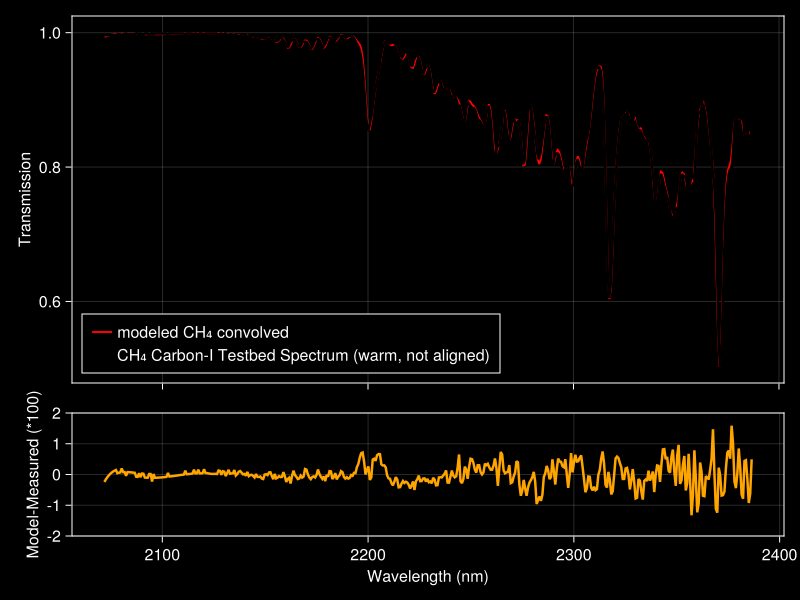

In [46]:
with_theme(plotFit, theme_black())

> Plot a subset of the range for all iterations (showing quick convergence)

In [27]:

y_fit = forward_model_testbed(x_all[:,end]);

f = Figure(resolution = (800, 600))
ii = ind .+1 
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
for iter = 1:n_iter
    lines!(ax,  getGrid(x_all[:,iter], ind), forward_model_testbed(x_all[:,iter]),  linewidth = 1.0, label = "modeled CH₄ at iteration $iter")
end
lines!(ax, testbed_ch4[ii,1], y, color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(ax,position = :lb)
xlims!(ax, (2190, 2310))
ylims!(ax, (0.75,1))
f

MethodError: MethodError: no method matching getGrid(::Vector{Float64}, ::UnitRange{Int64})
The function `getGrid` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  getGrid(::Any; ind)
   @ Main ~/code/gitHub/CarbonI/src/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:48


---

Now we just try to run the fit over a smaller wavelength range, which should provide even better fits as the SRF might vary across the FPA a bit. The residuals are indeed quite a bit better in the strong methane feature at 2.2µm. 

In [28]:
# Run a smaller subset:
ind= 150:300
n_iter = 3
# Use the testbed spectrum divided by its maximum as input spectrum to be fitted:
y = testbed_ch4[:,2]./maximum(testbed_ch4[:,2])
# Subselect only for the given detector indices (offset by 1 as Julia is one-index based)
y = y[ind.+1];
# Set the prior of the first polynmial term to the maximum of the measured spectrum (this ensures less iterations!)
x[6] = maximum(y)
# Define the measurement error covariance matrix (see CSR Box). This is arbitrarily chose here, in real life and simulations we use an instrument model to estimate this.
Se = Diagonal((0.002*y).^2);

# run iterations
for i=1:n_iter
    K = FiniteDiff.finite_difference_jacobian(forward_model_testbed,x_all[:,i]);
    # Perfom nonlinear Bayesian update (following Rodgers)
    F = forward_model_testbed(x_all[:,i]);
    iGain = inv(K'inv(Se)K + inv(Sa))K'inv(Se);
    # Compute retrieved state vector at iteration i
    x_all[:,i+1] = xa + iGain * (y - F + K *(x_all[:,i]-xa));
end

In [29]:
f = Figure(resolution = (800, 600))
ii = ind .+1 
ax = Axis(f[1, 1], xlabel = "Wavelength (nm)", ylabel = "Transmission")
ax2 = Axis(f[2, 1], xlabel = "Wavelength (nm)", ylabel = "Model-Measured (*100)")
rowsize!(f.layout, 2, Relative(0.25))

for iter = 1:n_iter
    @show iter, "Fitted FWHM", x_all[5,iter]
    y_fit = forward_model_testbed(x_all[:,iter])
    gridi = getGrid(x_all[:,iter], ind)
    lines!(ax,  gridi, y_fit,  linewidth = 1.0, label = "modeled CH₄ at iteration $iter")
    lines!(ax2, gridi, (y_fit.-y)*100,  linewidth = 1., label = "Fit Residual at iteration $iter")
end
lines!(ax, testbed_ch4[ii,1], y, color = :black, linewidth = 2.5, label = "CH₄ Carbon-I Testbed Spectrum (warm, not aligned)")
axislegend(ax,position = :lb)
ax.xticklabelsvisible = false
ax.xlabelvisible = false
#xlims!(ax, (2190, 2310))
ylims!(ax, (0.75,1))
f

(iter, "Fitted FWHM", x_all[5, iter]) = (1, "Fitted FWHM", 2.5)


MethodError: MethodError: no method matching getGrid(::Vector{Float64}, ::UnitRange{Int64})
The function `getGrid` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  getGrid(::Any; ind)
   @ Main ~/code/gitHub/CarbonI/src/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:48
